# SpaceCharger


In [5]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.stats import gaussian_kde
import scipy.stats as stats
from typing import Callable, Literal, Optional
from numpy.typing import NDArray
%matplotlib inline

# my own little library for dealing with four vectors
import fourvectors as fv

# numba!
from numba import jit, prange

## Constants & Enums

In [6]:
### Constants
c = 3E8
EPSILON_0 = 8.85E-12
COULOMB_K = 1 / (4 * np.pi * EPSILON_0)

### Create enums of particle properties, could be useful for multi-species experiments
class Proton(Enum):
    NAME   = "PROTON"
    MASS   = 1.672E-27 #kg
    CHARGE = 1.602E-19 #C

class Electron(Enum):
    NAME   = "ELECTRON"
    MASS   = 9.109E-21 #kg
    CHARGE =-1.602E-19 #C

class Reference(Enum):
    """A particle that is simply here to be a reference point."""
    NAME   = "REFERENCE PARTICLE"
    MASS   = 0        #kg
    CHARGE = 0        #C

## Particle Class

In [7]:
### Create the particle class, this holds all of the nice info about each particle
class Particle():
    def __init__(
            self,
            species,
            pos0_3v = None,  # a three-position
            pos0_4v = None,  # a four-position
            v0_3v  = None,   # a three-velocity
            v0_4v  = None,   # a four-velocity
            frame  = "LAB"   # defaults to lab frame
        ):

        ### HANDLE INITIAL VELOCITIES

        # if no initial three-velocity specified, assume 0
        if v0_3v is None or v0_4v is None:
            v0_4v = np.array([0, 0, 0, 0])

        # if there is a 3v provided, convert it
        if v0_3v is not None:
            # otherwise set the four velocity to match it
            v0_4v = fv.to_four_velocity(v0_3v)

        ### HANDLE INITIAL POSITIONS

        # if no position specified, assume origin
        if pos0_3v is None or pos0_4v is None:
            pos0_4v = np.array([0, 0, 0, 0])

        # if there is a pos 3v provided, convert it
        if pos0_3v is not None:
            pos0_4v = fv.to_four_position(pos0_3v, 0)

        # Get the parameters from the species of particle
        self.name = species.NAME.value
        self.mass = species.MASS.value
        self.charge = species.CHARGE.value

        self.vel_4v = v0_4v    # four velocity
        self.pos_4v = pos0_4v  # four position
        self.frame  = frame

    ### Lorentz Boost Functionality
    def lorentz_boost_to(self, other):
        """Lorentz boost to another particle's frame"""
        # if the frame is lab, then we're boosting to another particle
        if self.frame == "LAB":
            self.frame = other.name
        else:
            self.frame = other.frame

        # first lorentz boost the velocity
        self.lorentz_boost_from_4v(other.vel_4v)

        # then shift it
        if self.name == "REFERENCE PARTICLE":
            # here, the particle is the reference, and becomes the new reference frame
            self.pos_4v = self.get_separation(other)
        else:
            # otherwise lorentz the separation vector given the velocity of the other
            # (likely the reference)
            self.pos_4v = np.linalg.matmul(
                    fv.lorentz_matrix_z_4v(other.vel_4v), self.get_separation(other)
                )

    def boost_as_reference(self):
        self.lorentz_boost_to(self)

    def lorentz_boost_from_4v(self, to_vel_4v):
        """Lorentz boost given a four-velocity"""
        lorentz_matrix = fv.lorentz_matrix_z_4v(to_vel_4v)
        self.vel_4v = np.linalg.matmul(lorentz_matrix, self.vel_4v)

    def lorentz_boost_from_3v(self, to_vel_3v):
        """Lorentz boost given a three-velocity"""
        self.lorentz_boost_from_4v(fv.to_four_velocity(to_vel_3v))

    def get_separation(self, other):
        """"get the separation vector between the two positions"""
        return self.pos_4v - other.pos_4v

    ### Getters
    def get_3v(self):
        return fv.to_three_velocity(self.vel_4v)

    def get_3p(self):
        return fv.to_three_position(self.pos_4v)

## Multi-Gaussian Fitting Regiment

In [8]:
gaussian = lambda x, sig, mu: np.exp(-(x - mu)**2/(2 * sig**2))

def plotNormalWithLine(s, sig=None, mu=None, title=None, opacity=None):
    _, bins, _ = plt.hist(s, 50, density=True, label = title, alpha = opacity)

    if sig is not None and mu is not None:
        plt.plot(bins, 1/(sig * np.sqrt(2 * np.pi)) *
                    np.exp( - (bins - mu)**2 / (2 * sig**2) ),
                linewidth=2, color='r')

class MultiGaussFit():
    def __init__(
                    self,
                    arr,
                    nbins:int = 50,
                    ngaussians:int = 1,
                    width:float = 10.0,
                    mesh = None
                ):

        # get the histogram and bins arrays from the input array
        histo, bins = np.histogram(arr, bins=nbins, density=True)

        # bins = (bins[1:] + bins[:-1])/2

        # if no mesh specified, then overwrite it with a guess
        if mesh is None:
            self.mesh = np.linspace(bins[0], bins[-1], 100000)
            print(f"[INFO] NO MESH SPECIFIED. ASSUMING: N=100000, \
                RANGE=({bins[0]}, {bins[-1]})")
        # if there IS a mesh, then sanitize it
        else:
            print(f"[INFO] MESH SPECIFIED. CHECKING...", end="")
            self._mesh_isclean(mesh)
            # if the mesh is clean, then we good
            self.mesh = mesh


        # set up the array that contains where the gaussians will be centered
        eval_pts = np.zeros((ngaussians, 2))

        # first seed where the gaussians should probably be
        guesses = np.linspace(bins[1], bins[-2], ngaussians)

        # create a place to hold that gaussian fit
        fitted_line = 0
        normsum = 0
        for i in range(ngaussians):
            # get the index of the values closest
            lower_index = int((guesses[i] - bins[0])/(bins[1] - bins[0]))

            # then place the gaussian's peak location at
            eval_pts[i] = (
                (bins[lower_index]+bins[lower_index+1])/2,
                histo[lower_index]
                ) # (loc, amplitude)

            # create the gaussians
            fitted_line += eval_pts[i][1] * gaussian(self.mesh, sig=width,
                                                        mu=eval_pts[i][0])
            normsum += eval_pts[i][1] * (width * np.sqrt(2 * np.pi))

        fitted_line /= normsum

        # store the input params for future use
        self.arr = arr
        self.ngaussians = ngaussians
        self.nbins = nbins
        self.width = width

        # store the important calculated things
        self.histo = histo
        self.bins = bins
        self.fitted_line = np.array(fitted_line, dtype=np.float64)

    def _mesh_isclean(self, mesh):
        """Ensures the mesh provided is uniformly spaced and monotonically increasing."""
        #uniform spacing check
        dx = np.diff(mesh)
        if not (np.allclose(dx, dx[0]) and np.all(dx > 0)):
            raise ValueError("Mesh is not clean!!!")
        else:
            print(" (PASS)")

    def __call__(self, val, pltpoint = None):
        # get the closest point on the mesh
        # get the index of the values closest

        # clamp the value to be in the mesh range
        val = np.clip(val, self.mesh[0], self.mesh[-1])

        lower_index = int((val - self.mesh[0])/(self.mesh[1] - self.mesh[0]))

        # if the user wants to plot where they're getting the value
        if pltpoint is not None:
            plt.plot(self.mesh[lower_index], self.fitted_line[lower_index], "kx")

        return self.fitted_line[lower_index]

    def scale_by_factor(self, num):
        """Returns a new MultiGaussFit instance with the same fitted shape
        but scaled by num."""
        # Create a shallow copy
        new = MultiGaussFit.__new__(MultiGaussFit)

        # Copy all fields (except for the fitted line, which we'll scale)
        new.arr = self.arr
        new.nbins = self.nbins
        new.ngaussians = self.ngaussians
        new.width = self.width
        new.mesh = self.mesh
        new.bins = self.bins

        # Scale the PDF by a factor
        new.histo = self.histo * num
        new.fitted_line = self.fitted_line * num

        return new

    def plot_fit(self):
        # plot the where the peaks of the gaussians should be
        plt.stairs(self.histo, self.bins)
        # plt.plot(eval_pts[:,0], eval_pts[:,1], 'kx',  markersize=12)
        plt.plot(self.mesh, self.fitted_line, 'r-')

## Quadrature Rules
I ran some ```%%timeit``` tests on each of the quadrature rules here.

---
### Test 1 (Scalar)

~~~python
%%timeit
gaussQuad1D(fxn=lambda x: 10, x_bounds=np.array([-1.0, 1.0]), n=100)
~~~
Returns:
~~~
1.63 ms ± 40 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
~~~

~~~python
%%timeit
call_jit1DConst(
    x_bounds=np.array([-1.0, 1.0]),
    n=100,
    const=10.0
)
~~~
Returns:
~~~
2.02 ms ± 52.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
~~~

Speedup:  <span style="color:red">No</span>!

---

### Test 2
~~~python
%%timeit
gaussQuad3DCylVec(
    fxn = lambda s, z, phi : np.array([s,z,phi]),
    s_bounds = np.array([0, 4]),
    z_bounds = np.array([0, 10]),
    phi_bounds = np.array([0, 2*np.pi]),
    n=40
)
~~~
Returns:
~~~
228 ms ± 3.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
~~~

~~~python
%%timeit
call_jit3DCylVec(
    s_bounds = np.array([0, 4]),
    z_bounds = np.array([0, 10]),
    phi_bounds = np.array([0, 2*np.pi]),
    n=40
)
~~~
Returns:
~~~
2.06 ms ± 171 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
~~~

Speedup: <span style="color:lime">Yes</span>!

---

In [ ]:
from numpy.polynomial.legendre import leggauss

def linTransform(
        t:float,
        a:float,
        b:float ) -> float:
    """Linear transform from [-1,1] to [a,b]"""
    return 0.5 * ((b - a) * t + (a + b))

def gaussQuad1D(
    fxn: Callable[[float], float],
    x_bounds:NDArray[np.float64],
    n:int = 3 ) -> float:
    """1-D Gaussian Quadrature using Legendre Polynomials.
    Defaults to 1 quadrature point."""
    roots, weights = leggauss(n)

    a, b = x_bounds

    sum = 0
    # perform the summation
    for i in range(n):
        # get the roots into a,b from -1,1
        u = linTransform(roots[i], a, b)
        sum += weights[i] * fxn(u)

    # multiply by the coefficents from the variable substitution
    return 0.5 * (b - a) * sum

def gaussQuad3DVec(
        fxn: Callable[[float, float, float], NDArray[np.float64]],
        x_bounds: NDArray[np.float64],
        y_bounds: NDArray[np.float64],
        z_bounds: NDArray[np.float64],
        n: int = 3 ) -> NDArray[np.float64]:
    """Gaussian Quadrature of a 3D Vector Function. Defaults to 3 quadrature points."""
    roots, weights = leggauss(n)
    ax, bx = x_bounds
    ay, by = y_bounds
    az, bz = z_bounds

    result = np.zeros(3)

    for i in range(n):
        # get the root from -1->1 to ax->bx
        x = linTransform(roots[i], ax, bx)
        wx = weights[i]
        for j in range(n):
            y = linTransform(roots[j], ay, by)
            wy = weights[j]
            for k in range(n):
                z = linTransform(roots[k], az, bz)
                wz = weights[k]

                result += wx * wy * wz * np.array(fxn(x, y, z))

    scale = 0.125 * (bx - ax) * (by - ay) * (bz - az)
    return scale * result

def gaussQuad3DCylVec(
        fxn: Callable[[float, float, float], NDArray[np.float64]],
        s_bounds: NDArray[np.float64],
        z_bounds: NDArray[np.float64],
        phi_bounds: NDArray[np.float64],
        n: int = 3 ) -> NDArray[np.float64]:
    """Wrapper to integrate functions over cylindrical coordinates without
    needing to input the volume element (Jacobian). Defaults to 3 quadrature
    points."""

    # multiply our function by the volume element (jacobian)
    cyl_fxn = lambda r, z, phi: fxn(r, z, phi) * r
    return gaussQuad3DVec(cyl_fxn, s_bounds, z_bounds, phi_bounds, n)

def closestVal(
    val: float,
    array: NDArray[np.float64],
    dx: Optional[float] = None) -> int:
    """Gets the closest value to an array. Assumes the array is regularly spaced and
    increasing."""

    if dx == None:
        dx = array[1] - array[0]

    # clip val to be in the array
    val = np.clip(val, array[0], array[-1])

    return int((val - array[0])/dx)

### ```Numba```-Fied Quadrature Rules

In [10]:
@jit(nopython=True)
def _jit_linTransform(t:float, a:float, b:float ) -> float:
    """Linear transform from [-1,1] to [a,b]"""
    return 0.5 * ((b-a) * t + (a + b))

@jit(nopython=True, parallel=True)
def _jit_1DConst(
    x_bounds: NDArray[np.float64],
    const: float,
    weights: NDArray[np.float64],
    n: int = 3) -> float:
    """Gaussian quadrature for 1D constant integrand. Defaults ot 3 quadrature points.
    Parallelized with Numba."""
    a, b = x_bounds

    total = 0.0
    for i in prange(n):
        total += weights[i]

    return 0.5 * (b - a) * total * const

def call_jit_1DConst(
    x_bounds: NDArray[np.float64],
    const: float = 1.0,
    n: int = 3) -> float:
    """
    Wrapper to call the numba-fied gaussian quadrature for 1D constant integrand.
    """
    _, weights = np.polynomial.legendre.leggauss(n)
    return _jit_1DConst(x_bounds=x_bounds, const=const, weights=weights, n=n)


@jit(nopython=True, parallel=True)
def _jit_3DCylVec(
        s_bounds:   NDArray[np.float64],
        z_bounds:   NDArray[np.float64],
        phi_bounds: NDArray[np.float64],
        roots   :   NDArray[np.float64],
        weights :   NDArray[np.float64],
        n: int = 3 ) -> NDArray[np.float64]:
    """Gaussian Quadrature of a over Cylindrical Coordinates.
    Defaults to 3 quadrature points. Parallelized with Numba."""
    a_s, b_s = s_bounds
    a_z, b_z = z_bounds
    a_f, b_f = phi_bounds

    result = np.zeros(3)

    for i in prange(n):
        # get the root from -1->1 to a_s->b_s
        s = _jit_linTransform(roots[i], a_s, b_s)
        ws = weights[i]
        for j in range(n):
            z = _jit_linTransform(roots[j], a_z, b_z)
            wz = weights[j]
            for k in range(n):
                f = _jit_linTransform(roots[k], a_f, b_f)
                wf = weights[k]

                # multiply the fxn by the weights and vol element
                result += ws * wz * wf * s * _jit_3DCylFxn(s, z, f)

    return 0.125 * (b_s - a_s) * (b_z - a_z) * (b_f - a_f) * result

@jit(nopython=True)
def _jit_3DCylFxn(
        s: float,
        z: float,
        f: float) -> NDArray[np.float64]:

    return np.array([s, z, f])

def call_jit_3DCylVec(
        s_bounds:   NDArray[np.float64],
        z_bounds:   NDArray[np.float64],
        phi_bounds: NDArray[np.float64],
        n: int = 3 ) -> NDArray[np.float64]:
    """
    Wrapper to call the numba-fied gaussian quadrature for 1D constant integrand.
    This needs to be called as I cannot pass the leggauss weights into a numba function-
    it yells really loud when I try to do that.
    """
    roots, weights = np.polynomial.legendre.leggauss(n)
    return _jit_3DCylVec(s_bounds=s_bounds, z_bounds=z_bounds, phi_bounds=phi_bounds,
                            roots=roots, weights=weights, n=n)

## Longitudinal and Transverse Field Solvers

In [11]:
###
# STEP 0. Initialize all the functions that I will need
###

def longitudinalCoulombField(z_field: float, bunch_rad: float, bunch_length: float, quad_points: int = 3,  rho=None):
    """Compute 1D electric field with cylindrical regularization of radius R"""
    if rho is None:
        rho = lambda z: 1  # Uniform density

    def integrand(z_source):
        separation = z_field - z_source
        # use the 1d coulomb kernel for a cylinder of charge
        return rho(z_source) * separation / (separation**2 + bunch_rad**2)**(1.5)

    return gaussQuad1D(
        fxn=integrand,
        x_bounds=np.array((-bunch_length/2, bunch_length/2)),
        n=quad_points
    ) * COULOMB_K

def transverseCoulombField(
    field_pt: NDArray[np.float64],
    bunch_rad: float,
    bunch_length: float,
    quad_points: int = 3,
    rho=None) -> NDArray[np.float64]:
    """Compute radial E-field from a finite charged cylinder using Jefimenko's first term.
    Field is evaluated at a point R away from the cylinder's axis. Field point should be
    in Cartesian coordinates."""

    if rho is None:
        rho = lambda s, z, phi: 1  # Uniform density

    def integrand(s, z, phi):
        # convert the source and field point to be in cartesian
        source_pt = np.array([s * np.cos(phi), s * np.sin(phi), z])
        separation = field_pt - source_pt
        return rho(s, z, phi) * separation / norm(separation)**3

    return gaussQuad3DCylVec(
        fxn=integrand,
        s_bounds=np.array((0, bunch_rad)),
        z_bounds=np.array((-bunch_length / 2, bunch_length / 2)),
        phi_bounds=np.array((0, 2 * np.pi)),
        n=quad_points
    ) * COULOMB_K

### ```Numba```-Fied L/T Solvers

In [12]:
@jit(nopython=True)
def rho_interp(val, mesh, fitted_line, dx):
    # Clamp to mesh range
    val = np.clip(val, mesh[0], mesh[-1])

    # Nearest-neighbor interpolation
    idx = int((val - mesh[0]) / dx)
    return fitted_line[idx]


@jit(nopython=True)
def _jit_transverseField(
    field_pt: NDArray[np.float64],
    bunch_rad: float,
    bunch_length: float,
    roots: NDArray[np.float64],
    weights: NDArray[np.float64],
    mesh: NDArray[np.float64],
    rho_line: NDArray[np.float64],
    n: int = 3) -> NDArray[np.float64]:

    # TODO: mayhaps get rid of a_s & a_f for speeeed? is an unnecessary assign
    # but this might just get patched away in the JIT optimizations
    a_s, b_s = 0, bunch_rad
    a_z, b_z = -bunch_length / 2, bunch_length / 2
    a_f, b_f = 0, 2*np.pi

    result = np.zeros(3)

    for i in prange(n):
        # get the root from -1->1 to a_s->b_s
        s = _jit_linTransform(roots[i], a_s, b_s)
        ws = weights[i]
        for j in range(n):
            z = _jit_linTransform(roots[j], a_z, b_z)
            wz = weights[j]

            idz = int((z - mesh[0]) / (mesh[1] - mesh[0]))
            rho = 0 if s > bunch_rad else rho_line[idz]

            for k in range(n):
                f = _jit_linTransform(roots[k], a_f, b_f)
                wf = weights[k]

                # NOTE: optimization- get rid of norm for my own thing
                # may be necessary because numba might throw a fit

                separation = np.array([
                    field_pt[0] - s * np.cos(f), # x
                    field_pt[1] - s * np.sin(f), # y
                    field_pt[2] - z])            # z
                integrand = s * rho * separation / np.linalg.norm(separation)**3

                # multiply the fxn by the weights and vol element
                result += ws * wz * wf * integrand

                print(result)

    # the magic number is 1/8 * 1/ 4 pi epsilon 0
    return 0.125 * COULOMB_K * (b_s - a_s) * (b_z - a_z) * (b_f - a_f) * result


def call_jit_transverseField(
    field_pt: NDArray[np.float64],
    bunch_rad: float,
    bunch_length: float,
    rho: MultiGaussFit,
    n: int = 3) -> NDArray[np.float64]:
    """Compute radial E-field from a finite charged cylinder using the first term of
    Jefimenko's Equation. Field is evaluated at a point R away from the cylinder's axis.
    Field point should be in Cartesian coordinates. This is for a 1-D bunch along z and
    the optimizations here reflect that. Assumes regular grid spacing."""

    mesh, rho_line = rho.mesh, rho.fitted_line
    roots, weights = np.polynomial.legendre.leggauss(n)
    return _jit_transverseField(
        field_pt=field_pt,
        bunch_rad=bunch_rad,
        bunch_length=bunch_length,
        roots=roots,
        weights=weights,
        mesh=mesh,
        rho_line=rho_line,
        n=n)



## Actual Routine

In [13]:
###
# STEP 1. Initialize the particles
###
NUM_PARTICLES = 10000
MU_VEL, SIGMA_VEL = 2.6E8, 5E6   # average vel, 1sig of vel
MU_POS, SIGMA_POS = 0, 1E-4      # average pos, 1sig of pos

# create an array of NUM_PARTICLES Particle Objects with random velocities
particle_array = []

for i in range(NUM_PARTICLES):
    # i'm just going to do a whole bunch just going in the z direction
    # and give them a whole lot of positions
    particle_array.append(Particle(
        Electron,
        # generate a velocity that is clamped
        v0_3v=[0, 0, np.clip(np.random.normal(MU_VEL, SIGMA_VEL),0,c)],
        pos0_3v=[0 ,0, np.random.normal(MU_POS, SIGMA_POS)]
        ))

# get the velocities and positions of each particle
particle_vel = np.array([particle.get_3v() for particle in particle_array])
particle_pos = np.array([particle.get_3p()[0] for particle in particle_array])

# get the velocity and position of the reference particle
ref_vel = np.mean(particle_vel, axis=0)[0]
ref_pos = np.mean(particle_pos, axis=0)

# create reference particle
reference = Particle(Reference, v0_3v = ref_vel, pos0_3v = ref_pos)

Text(0.5, 1.0, 'Particle Position Comparison')

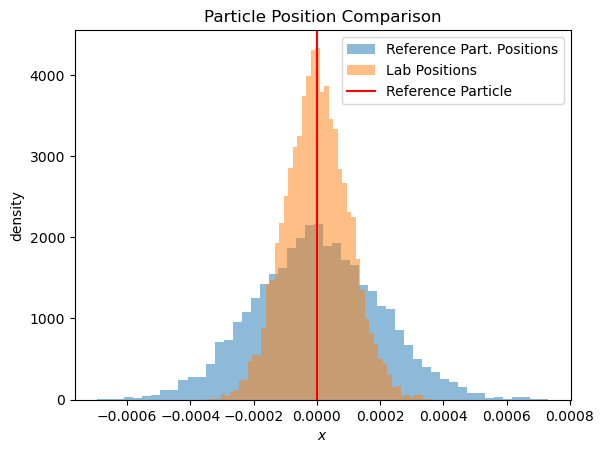

In [14]:
###
# STEP 2: Lorentz boost to the reference particle's frame
###

# Perform the lorentz boost for each particle
for particle in particle_array:
    particle.lorentz_boost_to(reference)

reference.boost_as_reference()

# get the velocities and positions of each particle
lb_particle_vel = np.array([particle.get_3v() for particle in particle_array])
lb_particle_pos = np.array([particle.get_3p()[0] for particle in particle_array])

# get the velocity and position of the reference particle
lb_ref_vel = np.mean(lb_particle_vel, axis=0)[0]
lb_ref_pos = np.mean(lb_particle_pos, axis=0)

plt.xlabel("$x$")
plt.ylabel("density")
plotNormalWithLine(lb_particle_pos[:,2], title="Reference Part. Positions", opacity = 0.5)
plotNormalWithLine(particle_pos[:,2], title="Lab Positions", opacity =0.5)
plt.axvline(x = ref_pos[0], color='r', label = 'Reference Particle')
plt.legend()
plt.title("Particle Position Comparison")

[INFO] NO MESH SPECIFIED. ASSUMING: N=100000,                 RANGE=(-0.0006941799752282735, 0.0007317056898159419)


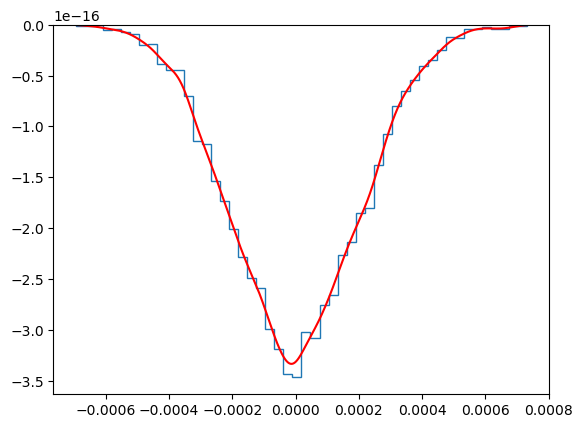

In [15]:
###
# STEP 3: Bin the distribution of particles in the Lorentz-boosted frame
###

# now, I can get the number density of the particles at a certain position
lb_mgf = MultiGaussFit(lb_particle_pos[:,2], nbins=50, ngaussians=50, width=.00003)

# i'll translate this into a charge density
charge_density = lb_mgf.scale_by_factor(Electron.CHARGE.value)

charge_density.plot_fit()

In [16]:
###
# STEP 4: Obtain the Longitudinal & Transverse Electric fields
#
# Take the bunch of particles to be a cylinder, and slice it up. Each slice
# will have a charge density determined by the bunched up particles.
#
###

### PARAMETERS ###

#bunch
bunch_rad = 1E-4  # radius of bunch (aka cylinder), is very thin
bunch_length = charge_density.bins[-1] - charge_density.bins[0]

# I'm going to take this charge density to be a really thin cylinder that changes along z
# it will be axisymmetric
rho_binned_cyl = lambda s, z, phi: charge_density(z) if s < bunch_rad else 0
rho_binned_1D = lambda s, z, phi: charge_density(z)

# try uniform distribution (on hold)
# rho_binned_cyl = lambda s, z, phi: 1 / (np.pi * rad_cyl**2 * bunch_length)

# meshes
MESH_PTS = 40
r_mesh = np.linspace(1E-5, 0.002, MESH_PTS)
z_mesh = np.linspace(charge_density.bins[0]-0.003, charge_density.bins[-1]+0.003, MESH_PTS)

# number of quadrature points
q_pts = 24

In [ ]:
# %%timeit
transverseCoulombField(
            field_pt=np.array([0.01, 0.0, 0.02]),
            bunch_rad=bunch_rad,
            bunch_length=bunch_length,
            quad_points=4,
            rho=rho_binned_cyl
        )

[-6.90727130e-22  2.02774395e-25 -1.42475741e-21]
[-1.98621139e-21  9.90704119e-25 -4.09436795e-21]
[-3.28169564e-21  2.02774395e-25 -6.76397849e-21]
[-3.97242277e-21 -1.83670992e-40 -8.18873591e-21]
[-7.95443756e-20  2.21853991e-23 -1.61260734e-19]
[-2.21280040e-19  1.08390803e-22 -4.48071607e-19]
[-3.63015705e-19  2.21853991e-23 -7.34882480e-19]
[-4.38587658e-19 -1.17549435e-38 -8.87954478e-19]
[-5.18956375e-19  2.35935689e-23 -1.04684387e-18]
[-6.69685021e-19  1.15268616e-22 -1.34454810e-18]
[-8.20413666e-19  2.35935689e-23 -1.64225233e-18]
[-9.00782383e-19 -2.93873588e-38 -1.80114172e-18]
[-9.01811281e-19  3.02050070e-25 -1.80313761e-18]
[-9.03740908e-19  1.47567307e-24 -1.80687714e-18]
[-9.05670534e-19  3.02050070e-25 -1.81061667e-18]
[-9.06699432e-19 -2.98465363e-38 -1.81261256e-18]
[-9.12848060e-19  8.59963552e-24 -1.82532533e-18]
[-9.24397954e-19  4.19466025e-23 -1.84909641e-18]
[-9.35947848e-19  8.59963552e-24 -1.87286750e-18]
[-9.42096476e-19 -2.93873588e-38 -1.88558027e-18]


array([-3.78022498e-14, -1.52223942e-32, -7.55731828e-14])

: 

In [ ]:
# %%timeit
call_jit_transverseField(
    field_pt=np.array([0.01, 0.0, 0.02]),
    bunch_rad=bunch_rad,
    bunch_length=bunch_length,
    n=40,
    rho=charge_density
)

[-6.55139418e-30  3.19602459e-37 -1.35691618e-29]
[-2.17635563e-29  4.22429253e-36 -4.50763925e-29]
[-4.55579014e-29  1.91899856e-35 -9.43589269e-29]
[-7.77924512e-29  5.66325318e-35 -1.61122699e-28]
[-1.18273571e-28  1.31365193e-34 -2.44966647e-28]
[-1.66757874e-28  2.60701739e-34 -3.45386658e-28]
[-2.22953800e-28  4.63110675e-34 -4.61778834e-28]
[-2.86523400e-28  7.56367051e-34 -5.93443184e-28]
[-3.57084373e-28  1.15522907e-33 -7.39587848e-28]
[-4.34212375e-28  1.66878306e-33 -8.99333868e-28]
[-5.17443563e-28  2.29773665e-33 -1.07172048e-27]
[-6.06277393e-28  3.03206695e-33 -1.25571088e-27]
[-7.00179624e-28  3.84951170e-33 -1.45019850e-27]
[-7.98585530e-28  4.71538483e-33 -1.65401363e-27]
[-9.00903296e-28  5.58407812e-33 -1.86593048e-27]
[-1.00651757e-27  6.40237148e-33 -2.08467455e-27]
[-1.11479319e-27  7.11434758e-33 -2.30893028e-27]
[-1.22507894e-27  7.66735533e-33 -2.53734902e-27]
[-1.33671154e-27  8.01817803e-33 -2.76855707e-27]
[-1.44901961e-27  8.13841911e-33 -3.00116397e-27]


In [ ]:
### EVALUATE!!! ###
lb_efld_z = np.zeros(len(z_mesh))                          # longitudinal E_z
lb_efld_r = np.zeros((len(z_mesh), len(r_mesh), 2))        # transverse E as vector field

for i_z, z in enumerate(z_mesh):
    # Longitudinal field at z
    lb_efld_z[i_z] = longitudinalCoulombField(
        z_field=z,
        bunch_rad=bunch_rad,
        bunch_length=bunch_length,
        quad_points=q_pts,
        rho=rho_binned_1D
    )

    print(f"Z: [ {i_z+1}/{len(z_mesh)} ] R: [" , end="")

    # Transverse fields for all r at this z
    for i_r, r in enumerate(r_mesh):
        lb_efld_r[i_z, i_r] = transverseCoulombField(
            field_pt=np.array([r, 0.0, z]),
            bunch_rad=bunch_rad,
            bunch_length=bunch_length,
            quad_points=q_pts,
            rho=rho_binned_cyl
        )
        print("*", end="")

    print("]")


Z: [ 1/40 ] R: [[-1.55142994e-30  5.78368873e-34  5.01952035e-28]
[-5.13841150e-30  7.59233464e-33  1.66240272e-27]
[-1.07071350e-29  3.40400703e-32  3.46328890e-27]
[-1.81731844e-29  9.82458684e-32  5.87512666e-27]
[-2.74290178e-29  2.20065289e-31  8.85833109e-27]
[-3.83482484e-29  4.14746658e-31  1.23639231e-26]
[-5.07867923e-29  6.85171215e-31  1.63343428e-26]
[-6.45793666e-29  1.01482910e-30  2.07043965e-26]
[-7.95316240e-29  1.36514305e-30  2.54023282e-26]
[-9.54110515e-29  1.68038665e-30  3.03509981e-26]
[-1.11942045e-28  1.90076303e-30  3.54691496e-26]
[-1.28810363e-28  1.98003090e-30  4.06727433e-26]
[-1.45678681e-28  1.90076303e-30  4.58763370e-26]
[-1.62209675e-28  1.68038665e-30  5.09944885e-26]
[-1.78089102e-28  1.36514305e-30  5.59431584e-26]
[-1.93041360e-28  1.01482910e-30  6.06410901e-26]
[-2.06833934e-28  6.85171215e-31  6.50111438e-26]
[-2.19272478e-28  4.14746658e-31  6.89815634e-26]
[-2.30191709e-28  2.20065289e-31  7.24871555e-26]
[-2.39447542e-28  9.82458684e-32  

ValueError: could not broadcast input array from shape (3,) into shape (2,)

-- BUNCH --
Length: 0.0009208372652208044, Radius: 0.0001


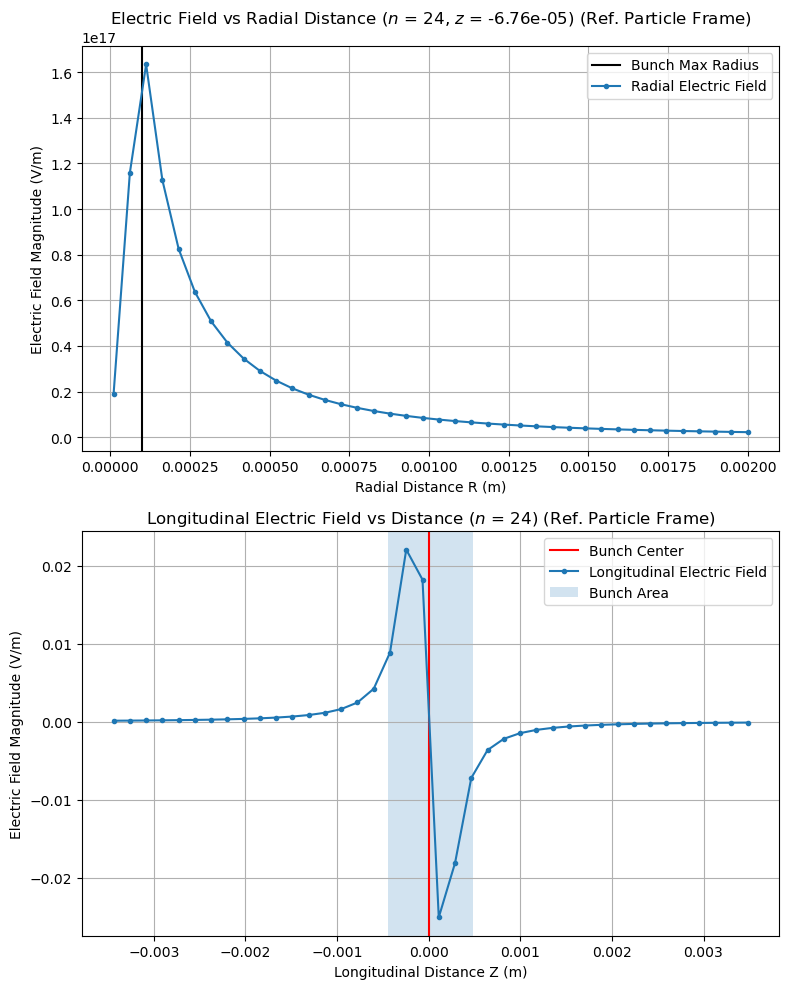

In [ ]:
print("-- BUNCH --")
print(f"Length: {bunch_length}, Radius: {rad_cyl}")

idz = closestVal(0, z_mesh)


fig, axs = plt.subplots(2, 1, figsize=(8, 10))  # 2 rows, 1 column

# Radial Efld
axs[0].grid()
axs[0].axvline(x=rad_cyl, label="Bunch Max Radius", color="k", linestyle='-')
axs[0].plot(r_mesh, np.array(lb_efld_r[idz, :])[:,0], '.-', label="Radial Electric Field")
axs[0].set_xlabel("Radial Distance R (m)")
axs[0].set_ylabel("Electric Field Magnitude (V/m)")
axs[0].set_title(f"Electric Field vs Radial Distance ($n$ = {q_pts}, $z$ = {z_mesh[idz]:0.2e}) (Ref. Particle Frame)")
axs[0].legend()

# Longitudinal Efld
axs[1].grid(True)
axs[1].axvline(x=lb_ref_pos[0], label='Bunch Center', color='red')
axs[1].plot(z_mesh, lb_efld_z, '.-', label="Longitudinal Electric Field")
axs[1].axvspan(lb_mgf.bins[0], lb_mgf.bins[-1], alpha=0.2, label='Bunch Area')
axs[1].set_xlabel("Longitudinal Distance Z (m)")
axs[1].set_ylabel("Electric Field Magnitude (V/m)")
axs[1].set_title(f"Longitudinal Electric Field vs Distance ($n$ = {q_pts}) (Ref. Particle Frame)")
axs[1].legend()

plt.tight_layout()
plt.show()

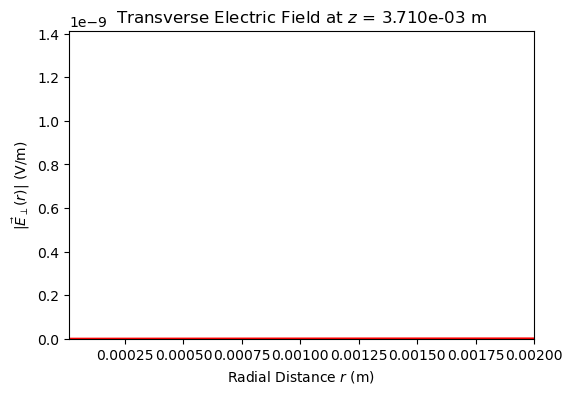

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

# Compute magnitude of transverse field
E_perp_mag = np.linalg.norm(lb_efld_r, axis=2)  # shape (Nz, Nr)

# Set up the figure
fig, ax = plt.subplots(figsize=(6, 4))
line, = ax.plot([], [], 'r-')
title = ax.set_title("")
ax.set_xlim(r_mesh[0], r_mesh[-1])
ax.set_ylim(0, 1.1 * np.max(E_perp_mag))
ax.set_xlabel("Radial Distance $r$ (m)")
ax.set_ylabel(r"$|\vec{E}_\perp(r)|$ (V/m)")

# Init function
def init():
    line.set_data([], [])
    title.set_text("")
    return line, title

# Animation update function
def update(i):
    line.set_data(r_mesh, E_perp_mag[i])
    title.set_text(f"Transverse Electric Field at $z$ = {z_mesh[i]:.3e} m")
    return line, title

ani = animation.FuncAnimation(
    fig, update, frames=len(z_mesh), init_func=init,
    interval=100, blit=True
)

HTML(ani.to_jshtml())

## Field transforms
The transforms for the fields for a frame moving in the $\hat{z}$ direction are
$$
\boxed{\bar{E}_x = \gamma \left( E_x - v B_y\right) \qquad \bar{E}_y = \gamma (E_y + v B_x) \qquad \bar{E}_z = E_z}
$$
$$
\boxed{\bar{B}_x = \gamma \left(B_x + \frac{v}{c^2} E_y\right) \qquad \bar{B}_y = \gamma \left(B_y - \frac{v}{c^2}E_x\right) \qquad \bar{B}_z = B_z}
$$
and the inverses are obtained by moving in the $-v$ direction
$$
\boxed{E_x = \gamma \left( \bar{E}_x + v \bar{B}_y\right) \qquad E_y = \gamma (\bar{E}_y - v \bar{B}_x) \qquad E_z = \bar{E}_z}
$$
$$
\boxed{B_x = \gamma \left(\bar{B}_x - \frac{v}{c^2} \bar{E}_y\right) \qquad B_y = \gamma \left(\bar{B}_y + \frac{v}{c^2} \bar{E}_x\right) \qquad B_z = \bar{B}_z}
$$

In [ ]:
###
# STEP 5: Test transforming the fields between frames
###

def fieldTransform(efld, bfld, v):
    """Returns the electric and magnetic fields in a frame moving in the *z* direction."""
    efld_bar = np.array([
        fv.gamma_3v(v) * (efld[0] - v * bfld[1]), # x
        fv.gamma_3v(v) * (efld[1] + v * bfld[0]), # y
        efld[2]                                   # z
        ])

    bfld_bar = np.array([
        fv.gamma_3v(v) * (bfld[0] + v * efld[1]/9E16),
        fv.gamma_3v(v) * (bfld[1] - v * efld[0]/9E16),
        bfld[2]
    ])

    return efld_bar, bfld_bar

def inverseFieldTransform(efld_bar, bfld_bar, v):
    """Returns the electric and magnetic fields in the **lab**
       frame from a frame moving in the *z direction"""
    efld = np.array([
        fv.gamma_3v(v) * (efld_bar[0] + v * bfld_bar[1]), # x
        fv.gamma_3v(v) * (efld_bar[1] - v * bfld_bar[0]), # y
        efld_bar[2]                                       # z
        ])

    bfld = np.array([
        fv.gamma_3v(v) * (bfld_bar[0] - v * efld_bar[1]/9E16),
        fv.gamma_3v(v) * (bfld_bar[1] + v * efld_bar[0]/9E16),
        bfld_bar[2]
    ])

    return efld, bfld

efld = [0, 1, 0]
bfld = [0, 0, 0]

e, b = inverseFieldTransform(efld, bfld, 2.6E8)
print(e/3E8,b)

# seems good enough

[0.00000e+00 6.68153e-09 0.00000e+00] [-5.79066e-09 0.00000e+00 0.00000e+00]


In [ ]:
###
# Step 6: Convert the fields in the reference particle frame to cartesian,
#         then convert that into the lab frame using the functions that I defined.
###

# (i just gotta do transverse)

x_mesh, y_mesh = z_mesh, z_mesh
Nx, Ny, Nz = len(x_mesh), len(y_mesh), len(z_mesh)

lb_efld_cart = np.zeros((Nx, Ny, Nz, 3))

dr = r_mesh[1] - r_mesh[0]
dz = z_mesh[1] - z_mesh[0]

for iz in range(Nz):
    z = z_mesh[iz]

    # Get longitudinal Ez
    z_clamped = np.clip(z, z_mesh[0], z_mesh[-1])
    idx_z = int((z_clamped - z_mesh[0]) / dz)
    Ez = lb_efld_z[idx_z]

    for iy in range(Ny):
        for ix in range(Nx):
            x = x_mesh[ix]
            y = y_mesh[iy]

            r = np.sqrt(x**2 + y**2)
            phi = np.arctan2(y, x)

            r_clamped = np.clip(r, r_mesh[0], r_mesh[-1])
            idx_r = int((r_clamped - r_mesh[0]) / dr)
            Er = lb_efld_r[idx_r]

            Ex = Er * np.cos(phi)
            Ey = Er * np.sin(phi)

            lb_efld_cart[iz, iy, ix, 0] = Ex
            lb_efld_cart[iz, iy, ix, 1] = Ey
            lb_efld_cart[iz, iy, ix, 2] = Ez

ValueError: setting an array element with a sequence.

In [ ]:
lb_efld_cart[1][1][1]

# at the x y z, gives the field strength

array([0.00000e+00, 0.00000e+00, 0.00000e+00])